# Taxi Trips and Traffic

Where most models use real-time data from users to predict arrival
times at any given moment, we believe they could be improved by including a predictive
element. Our intent is to use the NYC Taxi and Limousine Commission's yellow and green cab data set to estimate density of pickup and dropoffs at any given place and time. We will then use the density as a proxy for traffic to estimate the time it takes to arrive at a destination.

In [49]:
import edward as ed
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Data

Use the
[2015 NYC Yellow Cab Dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml),
which consists of pickup and dropoff coordinates for trips, along 
with metadata like cost, distance, and number of passengers. For the time being, we are only interested in trips that occurr entirely within the range from 1st street to 59th street, and 12th ave to 1st ave. This data can be easily visualized as a heat map. To Begin with we must break the data down into a grid. We will present several different options for doing so.

(256, 23)


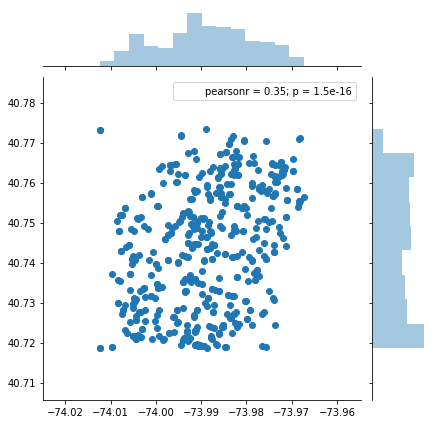

In [51]:
ed.set_seed(42)

data = pd.read_csv('data/results-20171021-152500.csv',
                   parse_dates=['pickup_datetime', 'dropoff_datetime'],
                   date_parser=pd.to_datetime)
pickup_coordinates = data.loc[:, ['pickup_longitude', 'pickup_latitude']].as_matrix()
dropoff_coordinates = data.loc[:, ['dropoff_longitude', 'dropoff_latitude']].as_matrix()
coords = np.concatenate((pickup_coordinates, dropoff_coordinates))
sns.jointplot(x=coords[:, 0], y=coords[:, 1])

## Model

A Gaussian process is a powerful object for modeling nonlinear
relationships between pairs of random variables. It defines a distribution over
(possibly nonlinear) functions, which can be applied for representing
our uncertainty around the true functional relationship.
Here we define a Gaussian process model for classification
(Rasumussen & Williams, 2006).

Formally, a distribution over functions $f:\mathbb{R}^D\to\mathbb{R}$ can be specified
by a Gaussian process
$$
\begin{align*}
  p(f)
  &=
  \mathcal{GP}(f\mid \mathbf{0}, k(\mathbf{x}, \mathbf{x}^\prime)),
\end{align*}
$$
whose mean function is the zero function, and whose covariance
function is some kernel which describes dependence between
any set of inputs to the function.

Given a set of input-output pairs
$\{\mathbf{x}_n\in\mathbb{R}^D,y_n\in\mathbb{R}\}$,
the likelihood can be written as a multivariate normal

\begin{align*}
  p(\mathbf{y})
  &=
  \text{Normal}(\mathbf{y} \mid \mathbf{0}, \mathbf{K})
\end{align*}

where $\mathbf{K}$ is a covariance matrix given by evaluating
$k(\mathbf{x}_n, \mathbf{x}_m)$ for each pair of inputs in the data
set.

The above applies directly for regression where $\mathbb{y}$ is a
real-valued response, but not for (binary) classification, where $\mathbb{y}$
is a label in $\{0,1\}$. To deal with classification, we interpret the
response as latent variables which is squashed into $[0,1]$. We then
draw from a Bernoulli to determine the label, with probability given
by the squashed value.

Define the likelihood of an observation $(\mathbf{x}_n, y_n)$ as

\begin{align*}
  p(y_n \mid \mathbf{z}, x_n)
  &=
  \text{Bernoulli}(y_n \mid \text{logit}^{-1}(\mathbf{x}_n^\top \mathbf{z})).
\end{align*}

Define the prior to be a multivariate normal

\begin{align*}
  p(\mathbf{z})
  &=
  \text{Normal}(\mathbf{z} \mid \mathbf{0}, \mathbf{K}),
\end{align*}

with covariance matrix given as previously stated.

Let's build the model in Edward. We use a radial basis function (RBF)
kernel, also known as the squared exponential or exponentiated
quadratic. It returns the kernel matrix evaluated over all pairs of
data points; we then Cholesky decompose the matrix to parameterize the
multivariate normal distribution.

In [4]:
X = tf.placeholder(tf.float32, [N, D])
f = MultivariateNormalTriL(loc=tf.zeros(N), scale_tril=tf.cholesky(rbf(X)))
y = Bernoulli(logits=f)

Here, we define a placeholder `X`. During inference, we pass in
the value for this placeholder according to data.

## Inference

Perform variational inference.
Define the variational model to be a fully factorized normal.

In [5]:
qf = Normal(loc=tf.Variable(tf.random_normal([N])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([N]))))

Run variational inference for `500` iterations.

In [6]:
inference = ed.KLqp({f: qf}, data={X: X_train, y: y_train})
inference.run(n_iter=5000)

5000/5000 [100%] ██████████████████████████████ Elapsed: 9s | Loss: 82.755


In this case
`KLqp` defaults to minimizing the
$\text{KL}(q\|p)$ divergence measure using the reparameterization
gradient.
For more details on inference, see the [$\text{KL}(q\|p)$ tutorial](/tutorials/klqp).
(This example happens to be slow because evaluating and inverting full
covariances in Gaussian processes happens to be slow.)